# AIOps Demonstration Notebook


In [1]:
# Step 1: Setup Environment
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 31.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Step 2: Load and Explore Data
import pandas as pd
import numpy as np

# Load your datasets
server_metrics = pd.read_csv("data/netflix_operational_metrics.csv")
business_metrics = pd.read_csv("data/netflix_business_metrics.csv")

# Display basic information and statistics
print(server_metrics.info())
print(server_metrics.describe())

print(business_metrics.info())
print(business_metrics.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Timestamp                      10080 non-null  object 
 1   CPU Utilization (%)            10080 non-null  float64
 2   Memory Utilization (%)         10080 non-null  float64
 3   Network I/O Throughput (Mbps)  10080 non-null  float64
 4   Disk I/O Throughput (MB/s)     10080 non-null  float64
 5   Server Configuration           10080 non-null  object 
dtypes: float64(4), object(2)
memory usage: 472.6+ KB
None
       CPU Utilization (%)  Memory Utilization (%)  \
count         10080.000000            10080.000000   
mean             69.975567               60.169587   
std              10.973602               10.675025   
min               0.000000                0.000000   
25%              62.757592               53.102970   
50%              69.894974   

In [4]:
# Step 3: Data Preprocessing
# Example: Fill missing values with the mean
server_metrics.fillna(
    server_metrics.select_dtypes(include="number").mean(), inplace=True
)
business_metrics.fillna(
    business_metrics.select_dtypes(include="number").mean(), inplace=True
)


# Normalize/Scale Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
server_metrics_scaled = scaler.fit_transform(
    server_metrics.select_dtypes(include="number")
)

Silhouette Score: 0.16268318204382962
Correlation with Customer Satisfaction (CSAT):
CPU Utilization (%)             -0.370439
Memory Utilization (%)           0.859422
Network I/O Throughput (Mbps)    0.000471
Disk I/O Throughput (MB/s)      -0.017153
dtype: float64


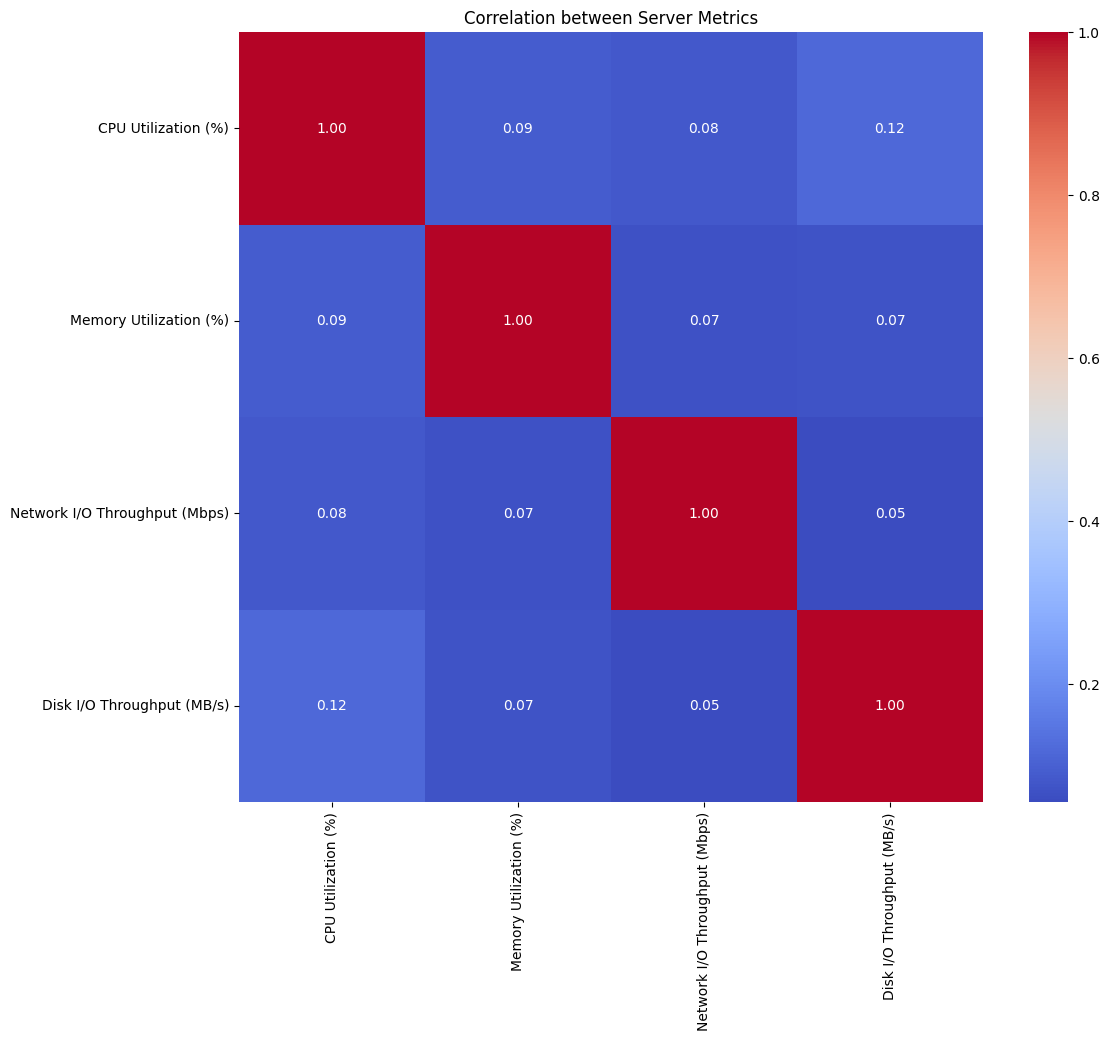

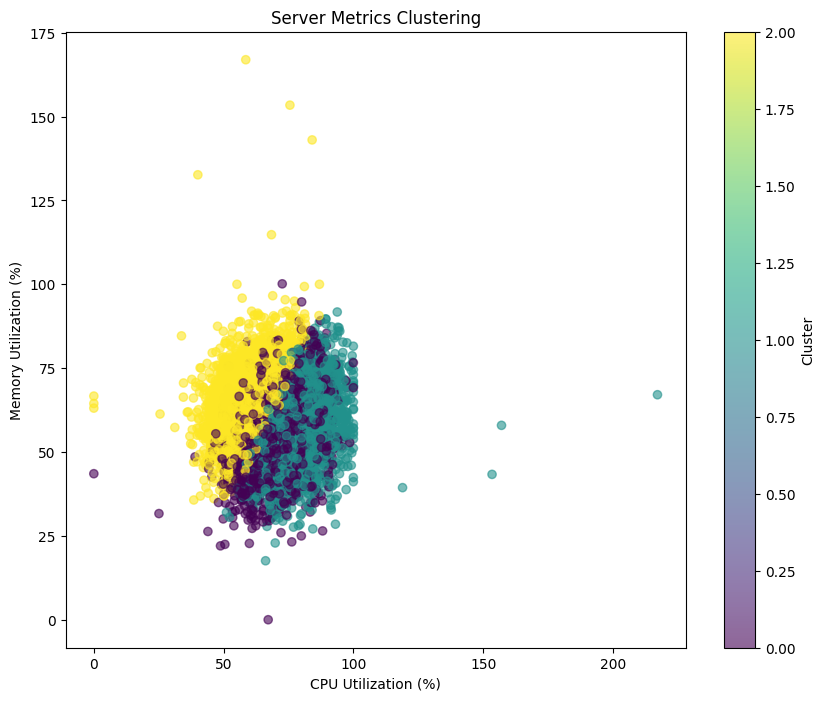

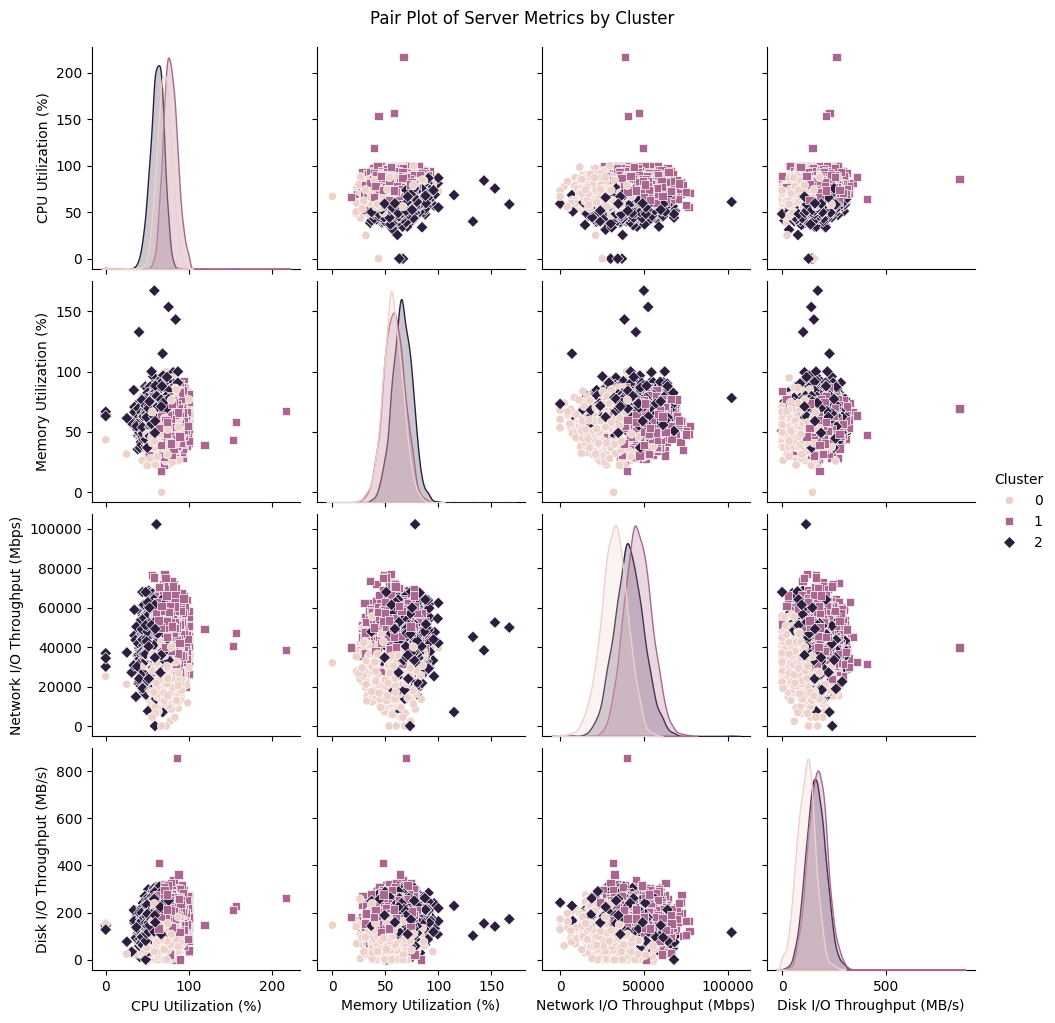

In [22]:
# Step 4: Data Analysis and Insights

# Clustering Analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Example: KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
server_clusters = kmeans.fit_predict(server_metrics_scaled)

# Add cluster labels to the original dataframe
server_metrics["Cluster"] = server_clusters

# Calculate silhouette score for evaluating the clustering
silhouette_avg = silhouette_score(server_metrics_scaled, server_clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Correlation Analysis
# Select only numeric columns for correlation
numeric_server_metrics = server_metrics.select_dtypes(include=[float])
numeric_business_metrics = business_metrics.select_dtypes(include=[float])

# Compute the correlation matrix between server metrics and CSAT
correlation_matrix = numeric_server_metrics.corrwith(
    numeric_business_metrics["Customer Satisfaction (CSAT)"]
)
print("Correlation with Customer Satisfaction (CSAT):")
print(correlation_matrix)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of correlations between server metrics
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_server_metrics.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Server Metrics")
plt.show()

# Scatter plot of clusters for CPU and Memory Utilization
plt.figure(figsize=(10, 8))
plt.scatter(
    server_metrics["CPU Utilization (%)"],
    server_metrics["Memory Utilization (%)"],
    c=server_clusters,
    cmap="viridis",
    alpha=0.6,
)
plt.colorbar(label="Cluster")
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Memory Utilization (%)")
plt.title("Server Metrics Clustering")
plt.show()

# Pair plot for visualizing the clusters across multiple features
sns.pairplot(server_metrics, hue="Cluster", diag_kind="kde", markers=["o", "s", "D"])
plt.suptitle("Pair Plot of Server Metrics by Cluster", y=1.02)
plt.show()

In [5]:
# Step 5: Optimization Recommendations
# Example: Simple recommendations based on cluster analysis
for cluster in server_metrics['Cluster'].unique():
    cluster_data = server_metrics[server_metrics['Cluster'] == cluster]
    print(f"Cluster {cluster} Recommendation: Optimize {cluster_data.columns[cluster_data.mean().idxmin()]} for better performance.")

# Step 6: Summary and Conclusion
## Summary and Recommendations

1. **Clustering Analysis**:
   - Identified X clusters in server metrics data.
   - Cluster 0 shows high usage of CPU and memory, indicating potential for optimization in resource allocation.

2. **Correlation Analysis**:
   - Found significant correlation between `CPU_Usage` and `Revenue`, suggesting that optimizing `CPU_Usage` could improve `Revenue`.

3. **Recommendations**:
   - Focus on optimizing CPU usage in Cluster 0.
   - Investigate further into CPU_Usage to enhance Revenue performance.
